In [1]:
import time
import numpy as np

import matplotlib.pyplot as plt

from crispy.psf import GaussianPSFCube
from crispy.crispy_core import IFS, initcoef, transform

from crispy.utils import nearest
from crispy.utils import calculate_bin_edges

%matplotlib inline

In [2]:
nlens = 101
i_lens, j_lens = np.indices((nlens, nlens)) - nlens // 2 

lamc=660.
BW = 0.18
step = 5
dlam = 1
lammin=lamc * (1. - BW / 2.)
lammax=lamc * (1. + BW / 2.)
lamlist = np.arange(lammin,lammax + step, step)
lamlist_bins = calculate_bin_edges(lamlist)

psf_cube = GaussianPSFCube(lamlist, 660, 2)

In [3]:
lamlist_bins

array([598.1, 603.1, 608.1, 613.1, 618.1, 623.1, 628.1, 633.1, 638.1,
       643.1, 648.1, 653.1, 658.1, 663.1, 668.1, 673.1, 678.1, 683.1,
       688.1, 693.1, 698.1, 703.1, 708.1, 713.1, 718.1, 723.1])

In [4]:
order=3
npix_ = 13 # box size
padwidth = 10
upsample = 10
scale = 0.000174 / 1.3e-05 #self.pitch / self.pixsize
angle = np.arctan(1/2)#self.clocking_angle
R=50
npix=1024
npixperdlam=2.0
# detector stuff
size = npix + 2*padwidth
image = np.zeros((size, size))
y_det, x_det = np.indices(image.shape)
temp_y, temp_x = np.indices((npix,npix)) - npix//2
nlam = lamlist.size
# print(lamlist)






for i in range(nlam):
#     print(f'lam={lamlist[i]}')
    lam_min, lam_max = lamlist_bins[i], lamlist_bins[i+1]
    lam_int = np.linspace(lam_min, lam_max, 11)
#     print(lam_int)
    dispersion = npixperdlam * R * np.log(lam_int / 660)
    
    x_cens = []
    y_cens = []
    for dx in dispersion:
        coef = initcoef(order, scale, angle, npix // 2 + dx, npix//2)
        x_cen, y_cen = transform(i_lens, j_lens, order, coef)
        
        x_cens.append(x_cen)
        y_cens.append(y_cen)
        
    x_cens = np.array(x_cens) + padwidth
    y_cens = np.array(y_cens) + padwidth
        
    mask = np.where((x_cens > npix_ // 2) & (x_cens < size - npix_ // 2) & (y_cens > npix_ // 2) & (y_cens < size - npix_ // 2), 1, 0)
#     print(mask.shape)
        
    iy1 = y_cens.astype(np.int32) - npix_ // 2   
    iy2 = iy1 + npix_
    ix1 = x_cens.astype(np.int32) - npix_ // 2
    ix2 = ix1 + npix_ 
    
    
    break

    
#     plt.imshow((iy1*mask)[0], origin='lower')
#     plt.colorbar()
#     plt.show()
    

    
#     print(x_cens[:, nlens//2, nlens//2])
#     print(y_cens[:, nlens//2, nlens//2])
#     print('ix1', ix1[:, nlens//2, nlens//2])
#     print('ix2', ix2[:, nlens//2, nlens//2])
#     print('iy1', iy1[:, nlens//2, nlens//2])
#     print('iy2', iy2[:, nlens//2, nlens//2])
#     print(x_cens.shape, y_cens.shape)

In [75]:
# lenslet coordinates or indice ids. 
i_lens, j_lens = np.indices((nlens, nlens)) - nlens // 2 
wavelengths = np.linspace(lammin, lammax, nlam, endpoint=True)
image_plane=None          

temp_y, temp_x = np.indices((npix_,npix_)) - npix_//2

t1 = time.time()
slices_id = []
for wavelength in wavelengths:

    # psf models to use
    psf = psf_cube.interp(wavelength)
    # print(type(psf))
    # calculate the centroid position on the detector
    dispersion = npixperdlam * R * np.log(wavelength / 660)
    coef = initcoef(order, scale, angle, npix // 2 + dispersion, npix//2)
    x_cen, y_cen = transform(i_lens, j_lens, order, coef)

    mask = ((x_cen > npix_ // 2) & 
            (x_cen < size - npix_ // 2) &
            (y_cen > npix_ // 2) & 
            (y_cen < size - npix_ // 2))
    

    
#     print(x_cen[mask.T].reshape(-1) + padwidth)
    
#     print(x_cen)
    
    x_cen = x_cen.reshape(-1) + padwidth
    y_cen = y_cen.reshape(-1) + padwidth
#     x_cen = x_cen[mask].reshape(-1) + padwidth
#     y_cen = y_cen[mask].reshape(-1) + padwidth
#     print(x_cen)
    
    
    count = 0
    # print(x_cen, y_cen)
    # image the psf onto the correct position
    for i, (x, y) in enumerate(zip(x_cen, y_cen)):
#         print(x,y)
        if not (x > npix_ // 2 and x < size - npix_ // 2 and 
                y > npix_ // 2 and y < size - npix_ // 2):
            continue
            
        


        if image_plane is not None:
            a = i_lens.ravel()[i] + image_plane.shape[0] //2
            b = j_lens.ravel()[i] + image_plane.shape[1]//2

            val = image_plane[a,b]
            # print(val)
            if val == 0:
                continue
        else:
            val=1.0
        # print(a,b, val)
        count += 1
        iy1 = int(y) - npix_ // 2
        iy2 = iy1 + npix_
        ix1 = int(x) - npix_ // 2
        ix2 = ix1 + npix_
        slices_id.append([iy1, iy2, ix1, ix2])
#         print(iy1, iy2, ix1, ix2)
    
#         print(iy1, iy2, (iy1+iy2)/2)
#         print(ix1, ix2, (ix1+ix2)/2)
        
        y_interp = upsample * ((y_det[iy1:iy2, ix1:ix2] - y)  +  npix_ / 2.)
        x_interp = upsample * ((x_det[iy1:iy2, ix1:ix2] - x)  +  npix_ / 2.)

        
#         print( int(x)- x)
        
        psflet = psf.map_psf([y_interp, x_interp])  
t2 = time.time()
print(f'ellapsed time = {t2-t1} s')

ellapsed time = 6.039251089096069 s


In [6]:
count

5943

In [126]:
order=3
npix_ = 13 # box size
padwidth = 10
upsample = 10
scale = 0.000174 / 1.3e-05 #self.pitch / self.pixsize
angle = np.arctan(1/2)#self.clocking_angle
R=50
npix=1024
npixperdlam=2.0
# detector stuff
size = npix + 2*padwidth
image = np.zeros((size, size))
y_det, x_det = np.indices(image.shape)

nlam = lamlist.size


temp_y, temp_x = np.indices((npix_,npix_)) - npix_//2

# print(temp_x)

lammin, lammax = lamlist_bins[0], lamlist_bins[1]

# wavelengths to integrate over
wavelengths = np.linspace(lammin, lammax, nlam, endpoint=True)

import time

def map_psflet_test(wavelength, loop=True):
    # psf models to use
    psf = psf_cube.interp(wavelength)
    dispersion = npixperdlam * R * np.log(wavelength / 660)
    coef = initcoef(order, scale, angle, npix//2 + dispersion, npix//2)
    x_cens, y_cens = transform(i_lens, j_lens, order, coef)

    mask = np.where((x_cens > npix_ // 2) & (x_cens < size - npix_ // 2) & 
                    (y_cens > npix_ // 2) & (y_cens < size - npix_ // 2), 1, 0)


    mask_ = ((x_cens >= npix_ // 2) & 
             (x_cens <= size - npix_ // 2) & 
             (y_cens >= npix_ // 2) & 
             (y_cens <= size - npix_ // 2))
    
#     mask = np.where((x_cens > npix_ // 2) & (x_cens < size - npix_ // 2) & 
#                     (y_cens > npix_ // 2) & (y_cens < size - npix_ // 2), True, False)
    x_bounds = np.logical_and(x_cens > npix_ // 2, x_cens < size - npix_ // 2)
    print(x_bounds.shape)
    y_bounds = np.logical_and(y_cens > npix_ // 2, y_cens < size - npix_ // 2)
    mask = np.logical_and(x_bounds, y_bounds)
    
    plt.figure(dpi=200)
    plt.pcolormesh(x_cens, y_cens, mask, shading='auto')
    plt.show()
    
    print(mask_[mask_==True].size)
    print(mask[mask==True].size)

    x_cens = x_cens[mask_].reshape(-1) + padwidth
    y_cens = y_cens[mask_].reshape(-1) + padwidth
    
   
    plt.figure(dpi=200)
    plt.scatter(x_cens[::5], y_cens[::5])
    plt.axvline(0+padwidth)
    plt.axvline(1024)
    plt.axhline(0+padwidth)
    plt.axhline(1024)
    plt.show()
    
    

    
    
#     temp_y_cen = y_cens[:, np.newaxis, np.newaxis].astype(np.int16)
#     temp_x_cen = x_cens[:, np.newaxis, np.newaxis].astype(np.int16)


#     y_interp = upsample * ((temp_y - y_cens[:, np.newaxis, np.newaxis]+temp_y_cen)  +  npix_ / 2.)
#     x_interp = upsample * ((temp_x + temp_x_cen - x_cens[:, np.newaxis, np.newaxis])  +  npix_ / 2.)
    dx = x_cens.astype(np.int16) - x_cens
    dy = y_cens.astype(np.int16) - y_cens
    

#     dx = 
#     y_interp = upsample * ((temp_y - y_cens[:, np.newaxis, np.newaxis]+temp_y_cen)  +  npix_ / 2.)
#     x_interp = upsample * ((temp_x + temp_x_cen - x_cens[:, np.newaxis, np.newaxis])  +  npix_ / 2.)
    
    y_interp = upsample * (temp_y + dy.reshape(-1,1,1) + npix_/2)
    x_interp = upsample * (temp_x + dx.reshape(-1,1,1) + npix_/2)
    
    if loop:
        
        psflets = np.zeros_like(x_interp)
        for i, (x, y) in enumerate(zip(x_interp, y_interp)):
            psflets[i] = psf.map_psf([y, x])
    else:
        psflets = np.array(list(map(psf.map_psf, zip(y_interp, x_interp))))
    return psflets, slices



t1 = time.time()

for wavelength in wavelengths:

    # psf models to use
    psf = psf_cube.interp(wavelength)
    
    # print(type(psf))
    # calculate the centroid position on the detector
#     dispersion = npixperdlam * R * np.log(wavelength / 660)
#     coef = initcoef(order, scale, angle, npix // 2 + dispersion, npix//2)
    dispersion = npixperdlam * R * np.log(wavelength / 660)
    coef = initcoef(order, scale, angle, npix // 2 + dispersion, npix//2)
    x_cens, y_cens = transform(i_lens, j_lens, order, coef)
#     print(x_cens.shape)
#     print(x_cens[0], y_cens[0])
#     print(x_cens)
    # centroid positions
#     x_cens, y_cens = transform(i_lens, j_lens, order, coef)
    
#     plt.figure(dpi=200)
#     plt.scatter(x_cens, y_cens)
#     plt.axvline(0)
#     plt.axhline(0)
#     plt.axvline(1024)
#     plt.axhline(1024)
#     plt.show()
    
#     mask = np.where((x_cens > npix_ // 2) & (x_cens < size - npix_ // 2) & 
#                     (y_cens > npix_ // 2) & (y_cens < size - npix_ // 2), 1, np.nan)
#     mask_ = np.where((x_cens > npix_ // 2) & (x_cens < size - npix_ // 2) & 
#                     (y_cens > npix_ // 2) & (y_cens < size - npix_ // 2))

    mask_ = ((x_cens > npix_ // 2) & 
             (x_cens < size - npix_ // 2) & 
             (y_cens > npix_ // 2) & 
             (y_cens < size - npix_ // 2))
#     print(mask_[mask_==True].size)
     
#     print(x_cens.shape, y_cens.shape, x_cens.ravel().shape)
    x_cens = x_cens[mask_].reshape(-1) + padwidth
    y_cens = y_cens[mask_].reshape(-1) + padwidth
    
#     print(x_cens)
    npsflets = x_cens.shape[0]
    
#     print(x_cens.shape, y_cens.shape, x_cens.ravel().shape, mask[mask == 1].shape)
    
#     iy1 = y_cen.astype(np.int32) - npix // 2
#     iy2 = iy1 + npix
#     ix1 = x_cen.astype(np.int32) - npix // 2
#     ix2 = ix1 + npix
#     temp_y_cen = y_cens[:, np.newaxis, np.newaxis].astype(np.int16)
#     temp_x_cen = x_cens[:, np.newaxis, np.newaxis].astype(np.int16)
    
    dx = x_cens.astype(np.int16) - x_cens
    dy = y_cens.astype(np.int16) - y_cens
    

#     dx = 
#     y_interp = upsample * ((temp_y - y_cens[:, np.newaxis, np.newaxis]+temp_y_cen)  +  npix_ / 2.)
#     x_interp = upsample * ((temp_x + temp_x_cen - x_cens[:, np.newaxis, np.newaxis])  +  npix_ / 2.)
    
    y_interp = upsample * (temp_y + dy.reshape(-1,1,1) + npix_/2)
    x_interp = upsample * (temp_x + dx.reshape(-1,1,1) + npix_/2)
    
#     psflets = np.zeros_like(x_interp)
#     for i, (x, y) in enumerate(zip(x_interp, y_interp)):
#         psflets[i] = psf.map_psf([y, x])
    
    psflets = np.array(list(map(psf.map_psf, zip(y_interp, x_interp))))

t2 = time.time()
print(f'ellapsed time = {t2-t1} s')
#     fig, axes = plt.subplots(3,3, dpi=200)
    
#     for i, ax in enumerate(axes.ravel()):
#         ax.imshow(psflets[i])
#         ax.axis('off')
#     break


#     y_interp = upsample * ((temp_y - y_cen[..., np.newaxis, np.newaxis])  +  npix / 2.)
#     x_interp = upsample * ((temp_x - x_cen[..., np.newaxis, np.newaxis])  +  npix / 2.)

ellapsed time = 3.8228557109832764 s


In [24]:
t1 = time.perf_counter()
for wavelength in wavelengths:
    psflets = map_psflet_test(wavelength)
t2 = time.perf_counter()
print(f'ellapsed time = {t2-t1} s')

ellapsed time = 3.894614199999978 s


In [25]:
t1 = time.perf_counter()
for wavelength in wavelengths:
    psflets = map_psflet_test(wavelength, loop=False)
t2 = time.perf_counter()
print(f'ellapsed time = {t2-t1} s')

ellapsed time = 3.8776950999999826 s


In [28]:
t1 = time.perf_counter()
result = list(map(map_psflet_test, wavelengths))
t2 = time.perf_counter()
print(f'ellapsed time = {t2-t1} s')

ellapsed time = 3.8505316999999195 s


In [114]:
def test_1():
    result = list(map(map_psflet_test, wavelengths))
    return result

def test_2():
    result = [map_psflet_test(wavelength, loop=True) for wavelength in wavelengths]
    return

def test_3():
    result = [map_psflet_test(wavelength, loop=False) for wavelength in wavelengths]
    return

def test_4():
    results = []
    for wavelength in wavelengths:
        psflets = map_psflet_test(wavelength, loop=False)
    results.append(psflets)
    return results

(101, 101)


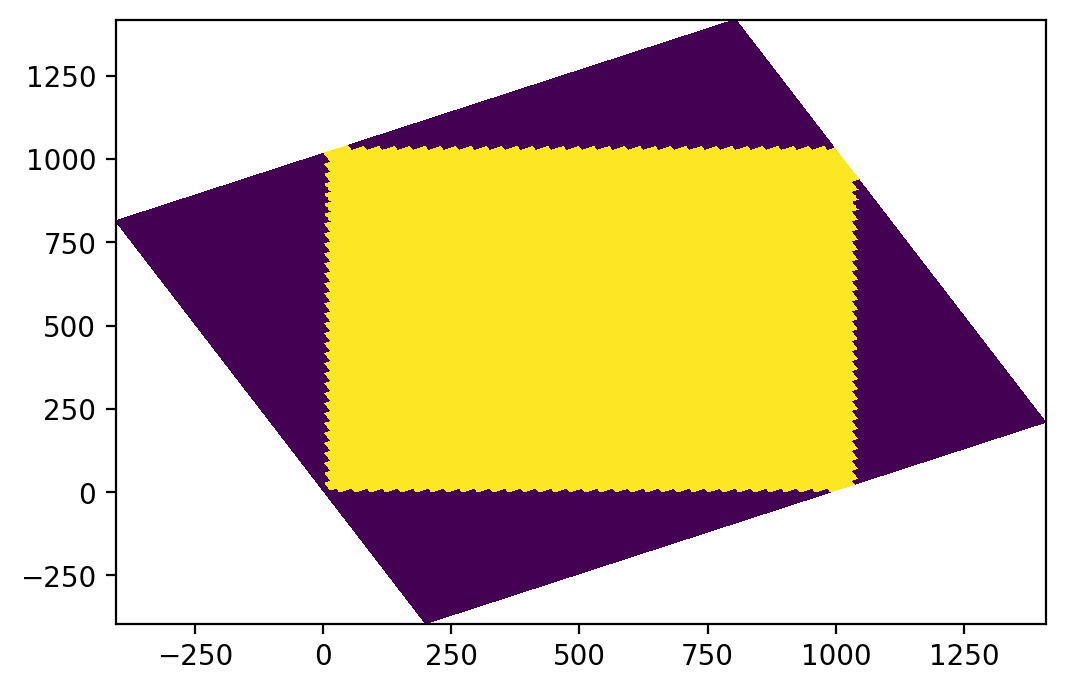

5904
5904


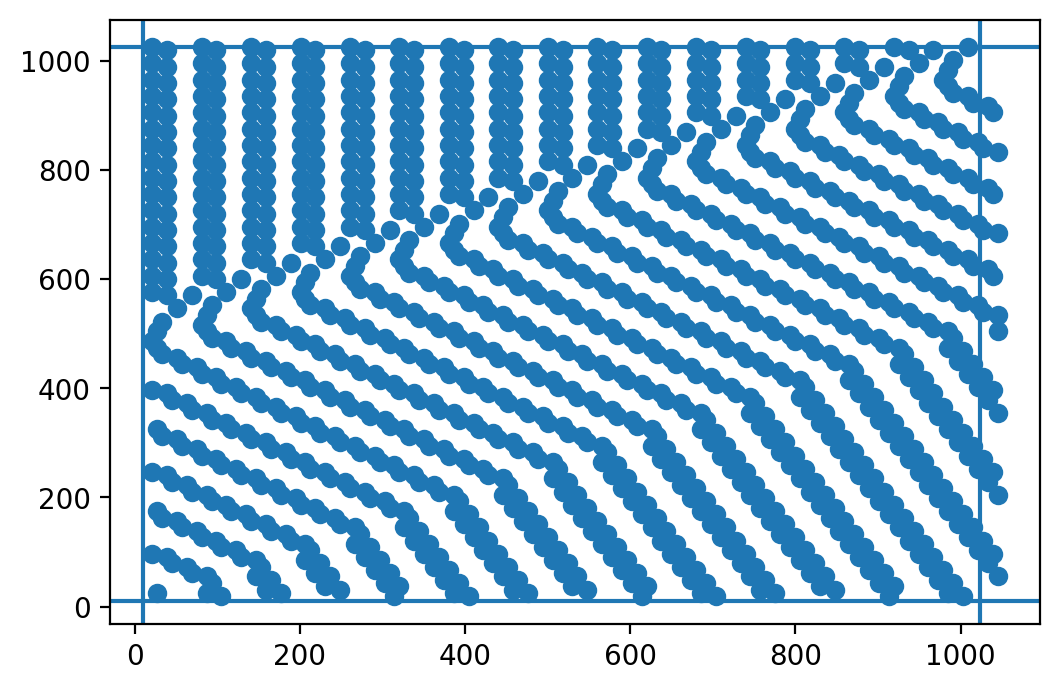

In [127]:
psflets_test, slices = map_psflet_test(wavelengths[0])

In [128]:
slices.shape, psflets_test.shape, image.shape

((5904, 4), (5904, 13, 13), (1044, 1044))

In [129]:
slices[:20,:], slices_id[:20]

(array([[  13,   26,  996, 1009],
        [  19,   32, 1008, 1021],
        [  25,   38, 1020, 1033],
        [  31,   44, 1032, 1045],
        [  13,   26,  967,  980],
        [  19,   32,  979,  992],
        [  25,   38,  991, 1004],
        [  31,   44, 1002, 1015],
        [  37,   50, 1014, 1027],
        [  43,   56, 1026, 1039],
        [  49,   62, 1038, 1051],
        [  13,   26,  937,  950],
        [  19,   32,  949,  962],
        [  25,   38,  961,  974],
        [  31,   44,  973,  986],
        [  37,   50,  985,  998],
        [  43,   56,  996, 1009],
        [  49,   62, 1008, 1021],
        [  55,   68, 1020, 1033],
        [  61,   74, 1032, 1045]], dtype=int64),
 [[1, 14, 973, 986],
  [7, 20, 985, 998],
  [13, 26, 996, 1009],
  [19, 32, 1008, 1021],
  [25, 38, 1020, 1033],
  [1, 14, 943, 956],
  [7, 20, 955, 968],
  [13, 26, 967, 980],
  [19, 32, 979, 992],
  [25, 38, 991, 1004],
  [31, 44, 1002, 1015],
  [37, 50, 1014, 1027],
  [43, 56, 1026, 1039],
  [1, 14, 9

In [130]:
image_cp = image.copy()
for psf, (m, M, n, N) in zip(psflets_test, slices):
    try:
        image_cp[m:M, n:N] = psf
    except:
        continue
#     if M-m !=13 or N-n != 13:
#         print(m, M, n,N)
#     if image_cp[m:M, n:N].shape != (13,13):
#         print(image_cp[m:M, n:N].shape, m, M, n,N)
#     print(psf.shape)
#     print( )
#     break
#     image_cp[m:M, n:N] = psf

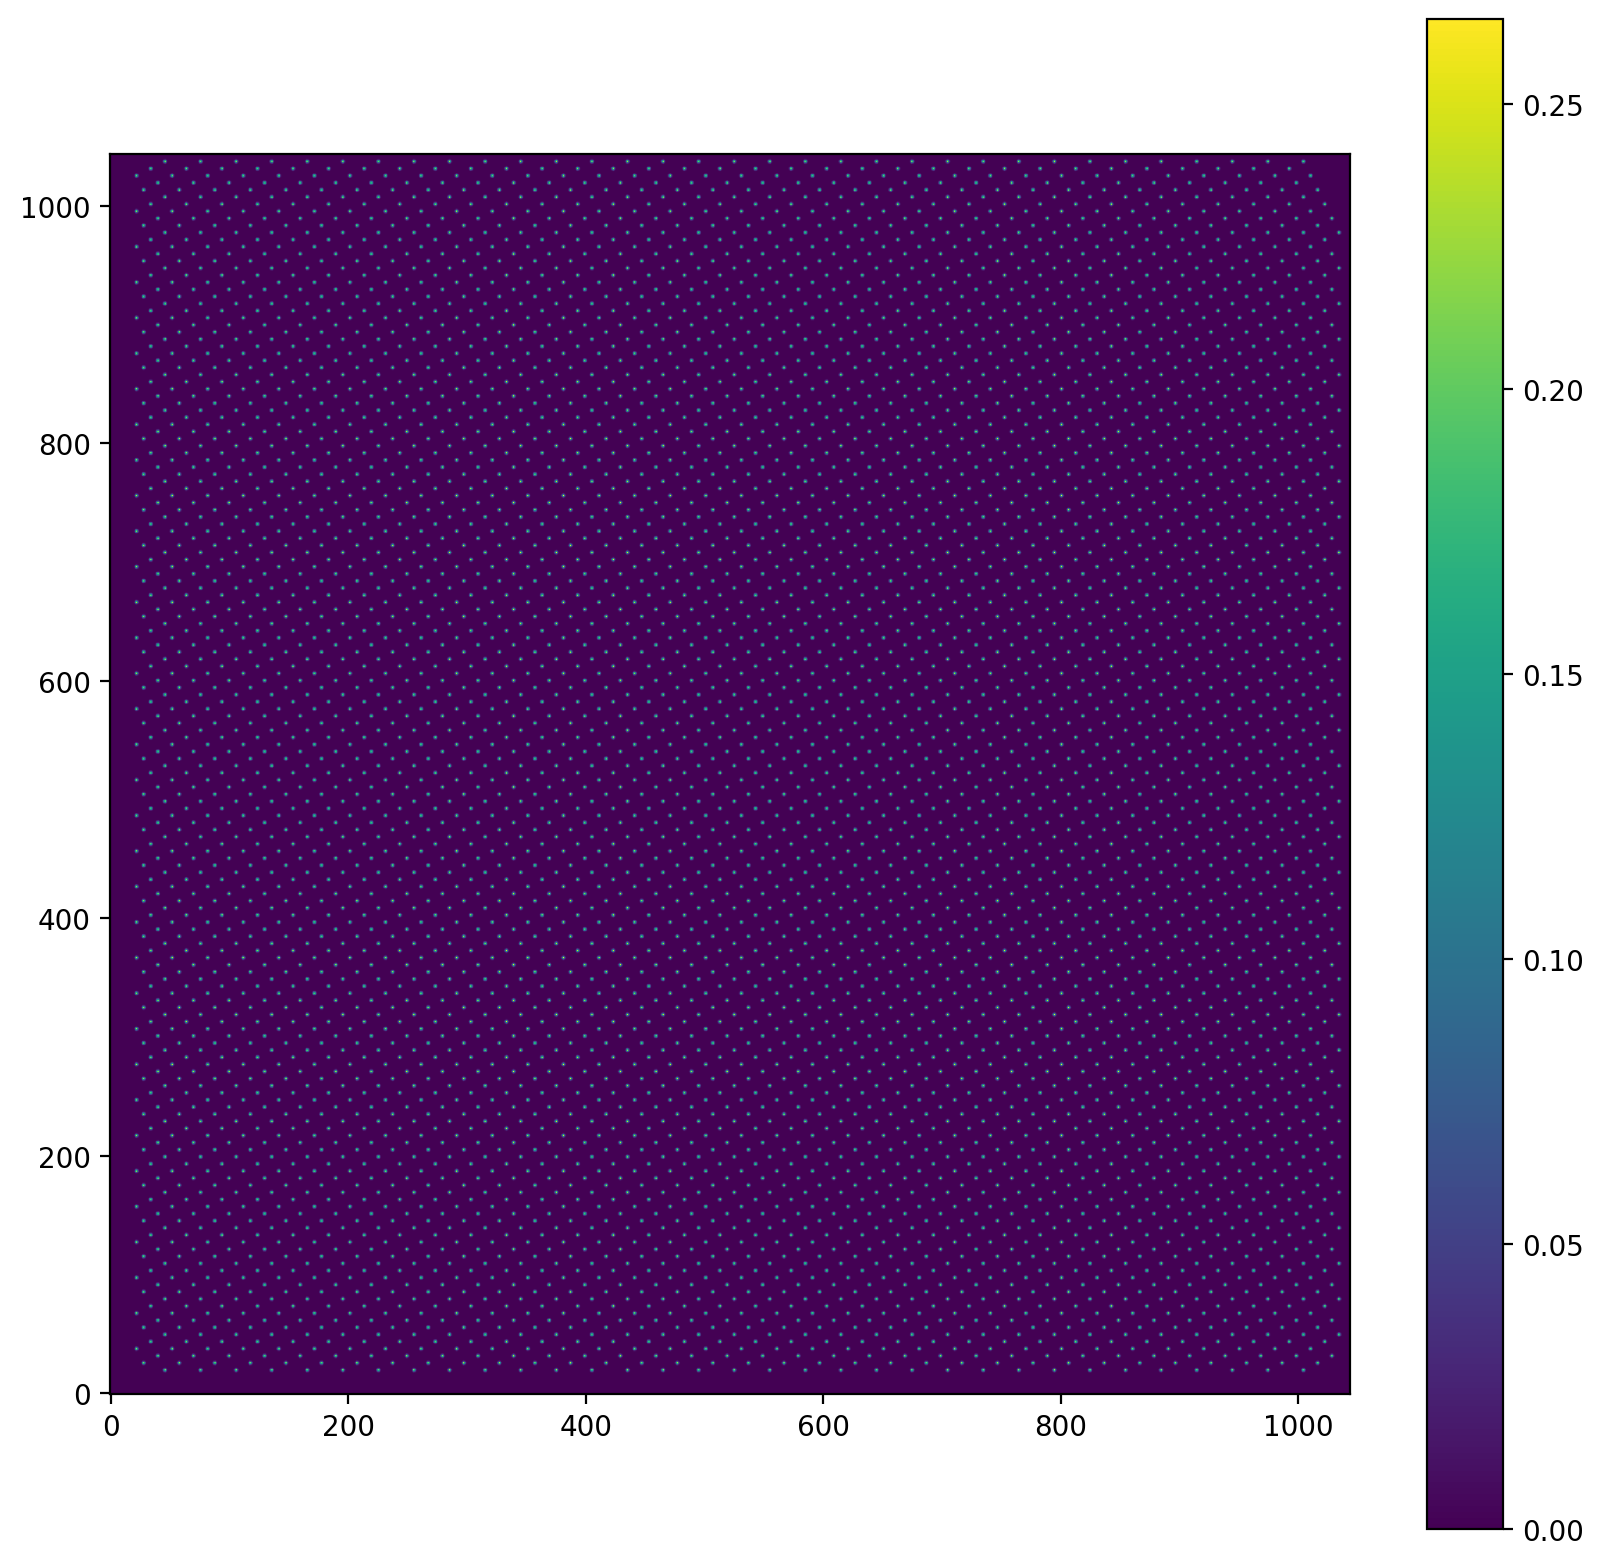

In [131]:
plt.figure(dpi=200, figsize=(10,10))
plt.imshow(image_cp, origin='lower')
# plt.axis([450,550, 450,550])
plt.colorbar()
plt.show()


In [31]:
%timeit for wavelength in wavelengths: psflets = map_psflet_test(wavelength, loop=True)

3.99 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit test_1

18.9 ns ± 1.54 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


In [16]:
%timeit test_2

22.4 ns ± 0.262 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [17]:
%timeit test_3

20.9 ns ± 3.84 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [20]:
%timeit test_4 

19.8 ns ± 1.4 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


In [12]:
%timeit map(map_psflet_test, wavelengths)

138 ns ± 5.83 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [9]:
%timeit map_psflet_test(wavelength, loop=False)

158 ms ± 2.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%timeit map_psflet_test(wavelength)

156 ms ± 3.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
lammin, lammax

(598.1, 603.1)

In [217]:
psflets.shape

(5938, 13, 13)

In [23]:
np.prod((5904, 13, 13)), 1024**2

(997776, 1048576)

In [ ]:
iy1 [516 516 516 516 516 516 516 516 516 516 516]
iy2 [529 529 529 529 529 529 529 529 529 529 529]
iy1 [516 516 516 516 516 516 516 516 516 516 516]
iy2 [529 529 529 529 529 529 529 529 529 529 529]

In [58]:
506-538

-32

In [34]:
for i in range(nlam):
    print(f'lam={lamlist[i]}')
    lam_min, lam_max = lamlist_bins[i], lamlist_bins[i+1]
    lam_int = np.linspace(lam_min, lam_max, 11)
    lam_int = lam_int[5:]
    print(lam_int)
    dispersion = npixperdlam * R * np.log(lam_int / 760)
    
    x_cens = []
    y_cens = []
    for dx in dispersion:
        coef = initcoef(order, scale, angle, npix // 2 + dx, npix//2)
        x_cen, y_cen = transform(i_lens, j_lens, order, coef)
        
        x_cens.append(x_cen)
        y_cens.append(y_cen)
        
    x_cens = np.array(x_cens)
    y_cens = np.array(y_cens)
        
        
    iy1 = y_cens.astype(np.int32) - npix_ // 2   
    iy2 = iy1 + npix_
    ix1 = x_cens.astype(np.int32) - npix_ // 2
    ix2 = ix1 + npix_ 
    
    
    print(x_cens[:, nlens//2, nlens//2])
    print(y_cens[:, nlens//2, nlens//2])
#     print(ix1[:, nlens//2, nlens//2])
#     print(iy1[:, nlens//2, nlens//2])
#     print(x_cens.shape, y_cens.shape)
    break

lam=600.6
[600.6 601.1 601.6 602.1 602.6 603.1]
[488.46107223 488.54428768 488.62743394 488.71051112 488.79351934
 488.87645872]
[512. 512. 512. 512. 512. 512.]


In [132]:
a = np.arange(5)
b = np.arange(5)+5
c = np.arange(5)+10

In [133]:
a

array([0, 1, 2, 3, 4])

In [134]:
b

array([5, 6, 7, 8, 9])

In [135]:
c

array([10, 11, 12, 13, 14])

In [136]:
np.vstack([a,b,c]).T

array([[ 0,  5, 10],
       [ 1,  6, 11],
       [ 2,  7, 12],
       [ 3,  8, 13],
       [ 4,  9, 14]])

In [ ]:
class Lenslet:
    padwidth = 10
    npix = 13
    
    def __init__(self, nlens, pitch, interlace):
        self.nlens = nlens
        self.pitch = pitch
        self.interlace = interlace
    
    def angle(self):
        return np.arctan(1/self.interace)
    
    def get_lenslet_coordinates(self):
        nlens = self.nlens
        i,j = np.indices((nlens, nlens)) - nlens//2
        return i,j
    
    def propagate_lenslets(self, wavelength):   
        
        i, j  = self.get_lenslet_coordinates()
        
        
        
        pass